<a href="https://colab.research.google.com/github/dunliangyang2010/Deep-Learning-practice/blob/master/Timeseries_classification_with_a_Transformer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3601, 500, 1), (3601,), (1320, 500, 1), (1320,))

In [4]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([1846, 1755]))

0


([<matplotlib.lines.Line2D at 0x7f48ec7031d0>], None)

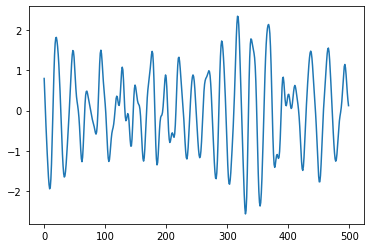

In [5]:
plt.plot(x_train[0]), print(y_train[0])

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

The main part of our model is now complete. We can stack multiple of those transformer_encoder blocks and we can also proceed to add the final Multi-Layer Perceptron classification head. Apart from a stack of Dense layers, we need to reduce the output tensor of the TransformerEncoder part of our model down to a vector of features for each data point in the current batch. A common way to achieve this is to use a pooling layer. For this example, a GlobalAveragePooling1D layer is sufficient.

In [8]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

## Train and evaluate

In [9]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 500, 1)      2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 500, 1)      7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

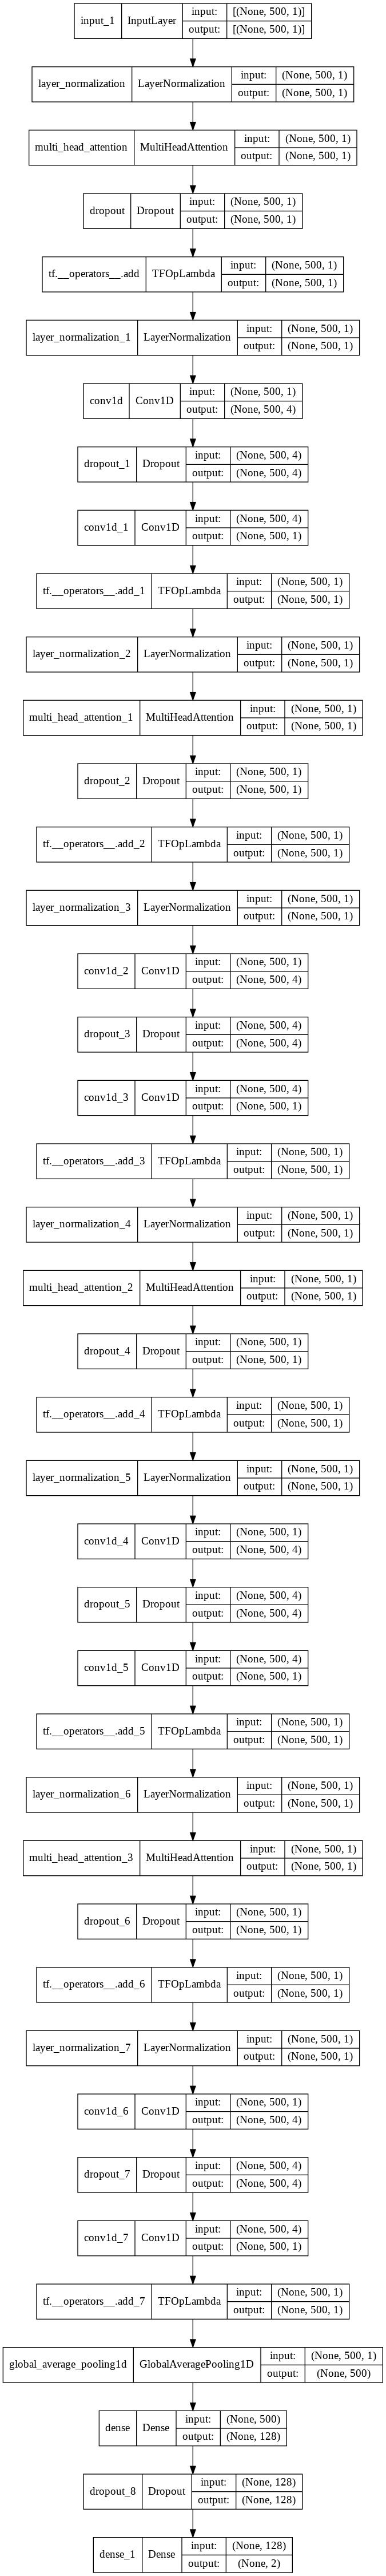

In [11]:
keras.utils.plot_model(model, show_shapes=True)

In [12]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

Epoch 1/200
45/45 [==============================] - 64s 1s/step - loss: 0.9585 - sparse_categorical_accuracy: 0.5229 - val_loss: 0.7527 - val_sparse_categorical_accuracy: 0.5423
Epoch 2/200
45/45 [==============================] - 53s 1s/step - loss: 0.8492 - sparse_categorical_accuracy: 0.5601 - val_loss: 0.6783 - val_sparse_categorical_accuracy: 0.5895
Epoch 3/200
45/45 [==============================] - 53s 1s/step - loss: 0.7737 - sparse_categorical_accuracy: 0.5809 - val_loss: 0.6395 - val_sparse_categorical_accuracy: 0.6338
Epoch 4/200
45/45 [==============================] - 53s 1s/step - loss: 0.7445 - sparse_categorical_accuracy: 0.6003 - val_loss: 0.6071 - val_sparse_categorical_accuracy: 0.6671
Epoch 5/200
45/45 [==============================] - 53s 1s/step - loss: 0.6979 - sparse_categorical_accuracy: 0.6424 - val_loss: 0.5870 - val_sparse_categorical_accuracy: 0.6768
Epoch 6/200
45/45 [==============================] - 53s 1s/step - loss: 0.6776 - sparse_categorical_accu

[0.335933119058609, 0.8590909242630005]

## Evaluate model on test data

In [ ]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

## Plot the model's training and validation loss

In [17]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(model.history[metric])
plt.plot(model.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

AttributeError: ignored

<Figure size 432x288 with 0 Axes>

## Conclusions

In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.